## Pytorch, AlexNet, CIFAR-10

Структура ноутбука:

! данные и обученые модели сохраняются в директорию - './data_cifar10'

1. Вводные по задаче.

2. Библиотеки.

3. Загрузка и просмотр данных.

4. Структура модели.

5. Эксперимент обучения модели pooling.kernel_size==2

6. Эксперимент обучения модели pooling.kernel_size==3

7. Тестирование модели.

8. Confusion Matrix

9. Результаты и выводы.

В этой практической работе вам предстоит решить задачу классификации изображений с применением знаний, полученных в модулях 3 и 4.

Для решения задач классификации изображений существует несколько классических архитектур, которые с успехом решают задачи классификации данных при условии достаточного количества данных.

Это:
- ResNet (Residual Networks).
- VGG (Visual Geometry Group).
- GoogLeNet (Inception).
- LeNet (Le относится к имени её создателя Yann LeCun, а Net переводится как сеть).
- AlexNet.

## Сравнительный анализ архитектур нейронных сетей в PyTorch

Вам необходимо самостоятельно реализовать одну из этих классических архитектур и обучить её на заданном датасете.

Возьмём архитектуру AlexNet, последовательность слоёв которой выглядит следующим образом:

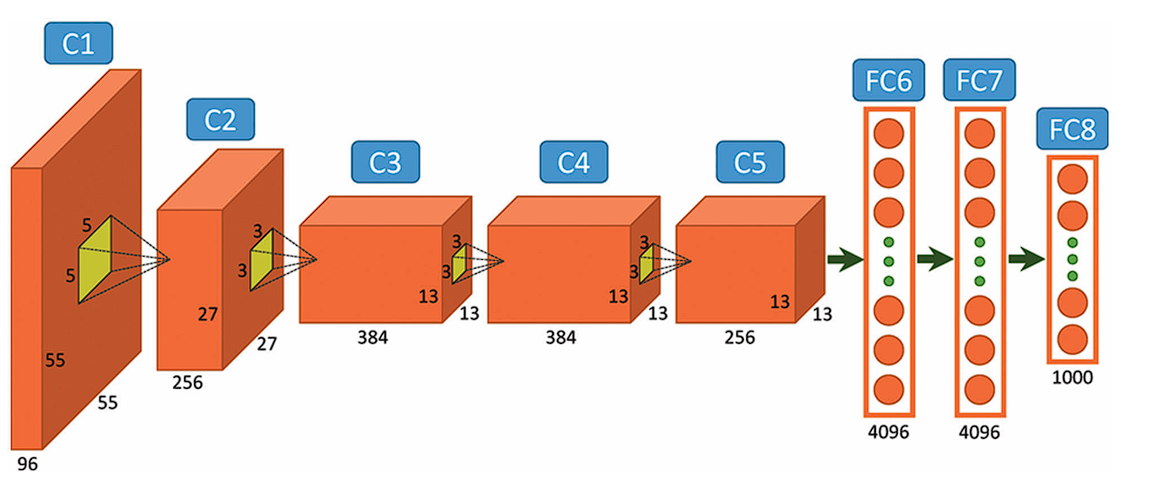



Самостоятельно реализуйте свёрточную сеть AlexNet, которая:
*   состоит из пяти свёрточных и трёх линейных слоёв;
*   умеет принимать на вход RGB-изображения.

После 1, 2 и 5-го свёрточного слоя примените pooling для уменьшения feature maps и извлечения наиболее значимых признаков.

В качестве функции активации используйте RELU. Это позволит сети быстрее обучаться по сравнению с традиционными функциями активации, такими как сигмоида или гиперболический тангенс.

Для борьбы с переобучением используйте Dropout в линейных слоях.

Для простоты решения задачи допустимо использовать везде kernel 3 × 3.

Размерность выходного слоя определите с учётом количества классов в исходных данных.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Обучите нейросеть AlexNet, которую вы реализовали до этого, на датасете CIFAR-10.

Для начала определите трансформации, которые вы сделаете с данными (аугментация, нормализация и прочее).

Загрузите данные из модуля torchvision.datasets.

## Библиотеки.

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchvision import datasets
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Загрузка и просмотр данных

In [2]:
# Определение преобразований для нормализации изображений
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Загрузка набора данных CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Загрузка набора данных CIFAR-10
#trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Scientist/Advanced/DeepLearning/data_torch', train=True, download=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/Scientist/Advanced/DeepLearning/data_torch', train=False, download=True, transform=transform)

In [5]:
# Создание загрузчиков данных
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [6]:
# Классы в наборе данных CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [7]:
# Вывод нескольких тренировочных изображений
def imshow(img):
    img = img / 2 + 0.5  # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
images, labels = next(iter(trainloader))

In [9]:
images[0].shape

torch.Size([3, 32, 32])

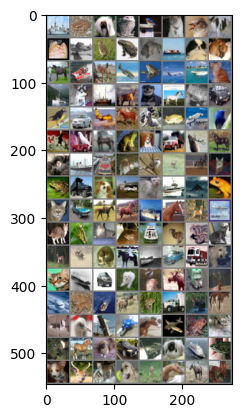

In [10]:
#dataiter = iter(trainloader)
#images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [11]:
len(trainset), len(testset)

(50000, 10000)

Визуализируйте по несколько примеров из тренировочной и тестовой выборок.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


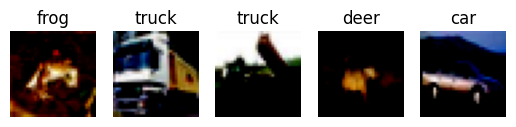

In [12]:
# Получение первых 5 изображений и их меток
train_images, train_labels = zip(*[trainset[i] for i in range(5)])

# Отображение изображений
for i, (img, label) in enumerate(zip(train_images, train_labels)):
    img = img.numpy().transpose(1, 2, 0)  # Перестановка осей для отображения
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(classes[label])  # Вывод метки класса
    plt.axis('off')  # Отключение осей

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


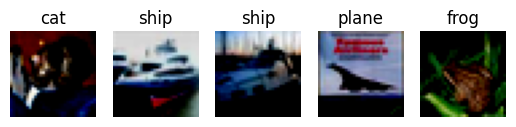

In [13]:
# Получение первых 5 изображений и их меток
test_images, test_labels = zip(*[testset[i] for i in range(5)])

# Отображение изображений
for i, (img, label) in enumerate(zip(test_images, test_labels)):
    img = img.numpy().transpose(1, 2, 0)  # Перестановка осей для отображения
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(classes[label])  # Вывод метки класса
    plt.axis('off')  # Отключение осей

plt.show()

## Структура модели.

Определите device, на котором будет запускаться обучение (GPU или CPU), модель AlexNet, оптимайзер и функцию потерь.
Подумайте и подберите значения learning rate и optimizer для решения этой задачи.

In [14]:
# Настройка устройства (GPU или CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Реализуйте свёрточную сеть AlexNet, которая:
*   состоит из пяти свёрточных и трёх линейных слоёв;
*   умеет принимать на вход RGB-изображения.

После 1, 2 и 5-го свёрточного слоя примените pooling для уменьшения feature maps и извлечения наиболее значимых признаков.

В качестве функции активации используйте RELU.

Для борьбы с переобучением используйте Dropout в линейных слоях.

Для простоты решения задачи допустимо использовать везде kernel 3 × 3.

Размерность выходного слоя = 10

In [15]:
len(classes)

10

Модель AlexNet была адаптирована для работы с набором данных CIFAR-10. Она состоит из пяти сверточных слоев и трех полносвязных слоев. 
За слоями conv - 1; 2; 3; следует слой подвыборки (pooling), который уменьшает размерность выходных данных и помогает извлекать наиболее значимые признаки.

In [16]:

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # добавлено: Дополнительный пулинг для уменьшения размерности x = self.pool(x)

        self.fc1 = nn.Linear(512 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))

        x = F.relu(self.conv4(x))

        x = F.relu(self.conv5(x))
        x = self.pool(x)

        # Дополнительный пулинг для уменьшения размерности
        x = self.pool(x)

        x = x.view(-1, 512 * 1 * 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)

        return x

self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

Размер выходных данных: 

Увеличение размера ядра до 3 может привести к более значительному уменьшению размерности выходных данных по сравнению с использованием ядра размером 2. Это может привести к более агрессивному уменьшению пространственных размеров feature maps.

Извлечение признаков: 

С увеличением размера ядра может быть потеряно больше информации о пространственных признаках изображения. Это может как помочь в извлечении более значительных признаков (за счет большего охвата), так и ухудшить качество распознавания из-за потери мелких деталей.

In [17]:
# Объявление модели и её перемещение на устройство
model = AlexNet().to(device)

In [18]:
images[0].shape

torch.Size([3, 32, 32])

In [19]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
         MaxPool2d-2           [-1, 64, 15, 15]               0
            Conv2d-3          [-1, 128, 13, 13]          73,856
         MaxPool2d-4            [-1, 128, 6, 6]               0
            Conv2d-5            [-1, 256, 6, 6]         295,168
            Conv2d-6            [-1, 512, 6, 6]       1,180,160
            Conv2d-7            [-1, 512, 6, 6]       2,359,808
         MaxPool2d-8            [-1, 512, 3, 3]               0
         MaxPool2d-9            [-1, 512, 1, 1]               0
           Linear-10                  [-1, 128]          65,664
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
          Dropout-13                   [-1, 64]               0
           Linear-14                   

In [20]:
for param in model.parameters():
    print(param.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([128, 512])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [21]:
# Функция обучения
def train(model, device, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0  # Переменная для накопления потерь
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Накопление потерь

    average_loss = total_loss / len(loader)  # Среднее значение потерь за эпоху
    return average_loss  # Возвращаем среднее значение потерь

# Функция тестирования
def test(model, device, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = correct / total
    return accuracy

In [22]:
# Настройка оптимизатора и функции потерь
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # сравнительно большая скорость обучения, хорошо для первого этапа.

In [23]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

## Эксперимент обучения модели pooling.kernel_size==2

In [25]:
# Перемещаем данные на device

n_epoch = 10

for epoch in range(n_epoch):
    model.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in trainloader:
        data, target = data.to(device), target.to(device)  # Перемещаем данные и цели на устройство
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epoch}, Loss: {running_loss / len(trainloader):.4f}')

    # Валидация модели после каждой эпохи
    model.eval()
    correct = 0

    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)  # Перемещаем данные и цели на устройство
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(testloader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 1.8792
Validation Accuracy: 0.4207
Epoch 2/10, Loss: 1.4132
Validation Accuracy: 0.5699
Epoch 3/10, Loss: 1.1420
Validation Accuracy: 0.6359
Epoch 4/10, Loss: 0.9653
Validation Accuracy: 0.6710
Epoch 5/10, Loss: 0.8398
Validation Accuracy: 0.6974
Epoch 6/10, Loss: 0.7173
Validation Accuracy: 0.7288
Epoch 7/10, Loss: 0.6293
Validation Accuracy: 0.7470
Epoch 8/10, Loss: 0.5341
Validation Accuracy: 0.7446
Epoch 9/10, Loss: 0.4484
Validation Accuracy: 0.7555
Epoch 10/10, Loss: 0.3689
Validation Accuracy: 0.7612


In [26]:
# Сохранение модели в формате .ckpt
torch.save(model.state_dict(), './data_cifar10/_first_model.ckpt')

# Сохранение обученной модели
checkpoint = {
    'model_state_dict': model.state_dict(),  # Состояние модели
    'optimizer_state_dict': optimizer.state_dict(),  # Состояние оптимизатора
    'epoch': n_epoch  # Текущий номер эпохи (если нужно возобновить обучение)
}

# Сохранение контрольной точки в файл .ckpt
torch.save(checkpoint, './data_cifar10/first_model_checkpoint.ckpt')

In [27]:
# Обучение модели
# Цикл обучения
#for epoch in range(10):  # 10 эпох
#    average_loss = train(model, device, trainloader, optimizer, criterion)  # Получаем среднее значение потерь
#    accuracy = test(model, device, testloader)
#    
#    print(f'Эпоха {epoch+1}, Точность на тестовом наборе: {accuracy:.2f}, Средняя потеря: {average_loss:.4f}')

self.pool = nn.MaxPool2d(kernel_size=2, stride=2), dataloader.batch_size=32, результаты обучения (время обучения на cpu порядка 8 часов):

Эпоха 1, Точность на тестовом наборе: 0.45

Эпоха 2, Точность на тестовом наборе: 0.61

Эпоха 3, Точность на тестовом наборе: 0.67

Эпоха 4, Точность на тестовом наборе: 0.71

Эпоха 5, Точность на тестовом наборе: 0.71

Эпоха 6, Точность на тестовом наборе: 0.74

Эпоха 7, Точность на тестовом наборе: 0.74

Эпоха 8, Точность на тестовом наборе: 0.75

Эпоха 9, Точность на тестовом наборе: 0.75

Эпоха 10, Точность на тестовом наборе: 0.74

## Эксперимент обучения модели pooling.kernel_size==3

In [24]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        # Обновим размерность входа для полносвязных слоев
        self.fc1 = nn.Linear(512 * 2 * 2, 128)  # после свертки и пуллинга
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))

        x = F.relu(self.conv4(x))

        x = F.relu(self.conv5(x))
        x = self.pool(x)

        # Убедитесь, что размерность x корректная
        x = x.view(x.size(0), -1)  # корректное изменение размерности

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)

        return x

In [25]:
# Объявление модели и её перемещение на устройство
model_cnn = AlexNet().to(device)

In [26]:
summary(model_cnn, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
         MaxPool2d-2           [-1, 64, 14, 14]               0
            Conv2d-3          [-1, 128, 12, 12]          73,856
         MaxPool2d-4            [-1, 128, 5, 5]               0
            Conv2d-5            [-1, 256, 5, 5]         295,168
            Conv2d-6            [-1, 512, 5, 5]       1,180,160
            Conv2d-7            [-1, 512, 5, 5]       2,359,808
         MaxPool2d-8            [-1, 512, 2, 2]               0
            Linear-9                  [-1, 128]         262,272
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
          Dropout-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 4,181,962
Trainable param

In [27]:
for param in model_cnn.parameters():
    print(param.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([128, 2048])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [28]:
# Создание загрузчиков данных
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [29]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [34]:
# Перемещаем данные на device

n_epoch = 10

for epoch in range(n_epoch):
    model_cnn.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in trainloader:
        data, target = data.to(device), target.to(device)  # Перемещаем данные и цели на устройство
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epoch}, Loss: {running_loss / len(trainloader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)  # Перемещаем данные и цели на устройство
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(testloader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 1.7746
Validation Accuracy: 0.4659
Epoch 2/10, Loss: 1.3423
Validation Accuracy: 0.5753
Epoch 3/10, Loss: 1.1287
Validation Accuracy: 0.6316
Epoch 4/10, Loss: 0.9729
Validation Accuracy: 0.6647
Epoch 5/10, Loss: 0.8499
Validation Accuracy: 0.6886
Epoch 6/10, Loss: 0.7430
Validation Accuracy: 0.7201
Epoch 7/10, Loss: 0.6588
Validation Accuracy: 0.7315
Epoch 8/10, Loss: 0.5791
Validation Accuracy: 0.7453
Epoch 9/10, Loss: 0.4883
Validation Accuracy: 0.7384
Epoch 10/10, Loss: 0.4257
Validation Accuracy: 0.7409


In [35]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), './data_cifar10/model.ckpt')

# Сохранение обученной модели
checkpoint = {
    'model_state_dict': model_cnn.state_dict(),  # Состояние модели
    'optimizer_state_dict': optimizer.state_dict(),  # Состояние оптимизатора
    'epoch': n_epoch  # Текущий номер эпохи (если нужно возобновить обучение)
}

# Сохранение контрольной точки в файл .ckpt
torch.save(checkpoint, './data_cifar10/model_checkpoint.ckpt')

## Оценка модели.

In [57]:

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # добавлено: Дополнительный пулинг для уменьшения размерности x = self.pool(x)

        self.fc1 = nn.Linear(512 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))

        x = F.relu(self.conv4(x))

        x = F.relu(self.conv5(x))
        x = self.pool(x)

        # Дополнительный пулинг для уменьшения размерности
        x = self.pool(x)

        x = x.view(-1, 512 * 1 * 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)

        return x

In [59]:
# Объявление модели и её перемещение на устройство
model_cnn = AlexNet().to(device)

In [61]:
# Загрузка контрольной точки
checkpoint = torch.load('./data_cifar10/first_model_checkpoint.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print(n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 2  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = AlexNet() 
model_cnn.load_state_dict(torch.load('./data_cifar10/_first_model.ckpt'))
model.eval()  # Установка модели в режим оценки

/tmp/ipykernel_5951/3811724415.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./data_cifar10/first_model_checkpoint.ckpt')


10


/tmp/ipykernel_5951/3811724415.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load('./data_cifar10/_first_model.ckpt'))


AlexNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [68]:
summary(model_cnn, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
         MaxPool2d-2           [-1, 64, 15, 15]               0
            Conv2d-3          [-1, 128, 13, 13]          73,856
         MaxPool2d-4            [-1, 128, 6, 6]               0
            Conv2d-5            [-1, 256, 6, 6]         295,168
            Conv2d-6            [-1, 512, 6, 6]       1,180,160
            Conv2d-7            [-1, 512, 6, 6]       2,359,808
         MaxPool2d-8            [-1, 512, 3, 3]               0
         MaxPool2d-9            [-1, 512, 1, 1]               0
           Linear-10                  [-1, 128]          65,664
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
          Dropout-13                   [-1, 64]               0
           Linear-14                   

In [62]:
# Инициализация переменных для хранения результатов
class_correct = [0] * 10  # Для каждого из 10 классов
class_total = [0] * 10

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in testloader:
        output = model_cnn(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(10):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(classes[i]) 
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

plane
Accuracy of class 0: 0.83
car
Accuracy of class 1: 0.85
bird
Accuracy of class 2: 0.61
cat
Accuracy of class 3: 0.68
deer
Accuracy of class 4: 0.73
dog
Accuracy of class 5: 0.54
frog
Accuracy of class 6: 0.84
horse
Accuracy of class 7: 0.79
ship
Accuracy of class 8: 0.82
truck
Accuracy of class 9: 0.85


In [63]:
def predict(image):
    #print('image shape:', image.shape)

    # Убедитесь, что размер входного изображения правильный
    if len(image.shape) == 3:  # Если входной тензор имеет форму (C, H, W)
        image = image.unsqueeze(0)  # Добавляем размер батча

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число

        pred = classes[predicted_label]  # Получаем предсказанную метку

    return pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7490196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54509807..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input dat

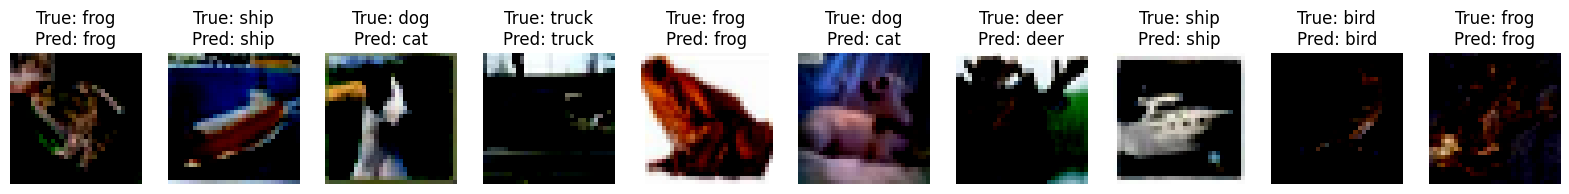

In [64]:
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(testset))
    image, label = testset[random_index]

    image_np = image.squeeze(0).permute(1, 2, 0).numpy()  # Изменяем порядок осей для отображения

    pred = predict(image)  # Предсказание для изображения

    axs[i].imshow(image_np)  # Убираем cmap для цветных изображений
    axs[i].set_title(f'True: {classes[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()

Оцените качество модели на тестовой выборке и выведите метрику.

In [65]:
# Оценка качества модели на тестовой выборке
correct = 0
total = 0

with torch.no_grad():  # Отключаем градиенты для повышения производительности
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        # Предсказание
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [66]:
# Выводим метрики
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 75.53%


## Confusion Matrix

Нарисуйте confusion_matrix.

In [69]:
# Получение предсказаний
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

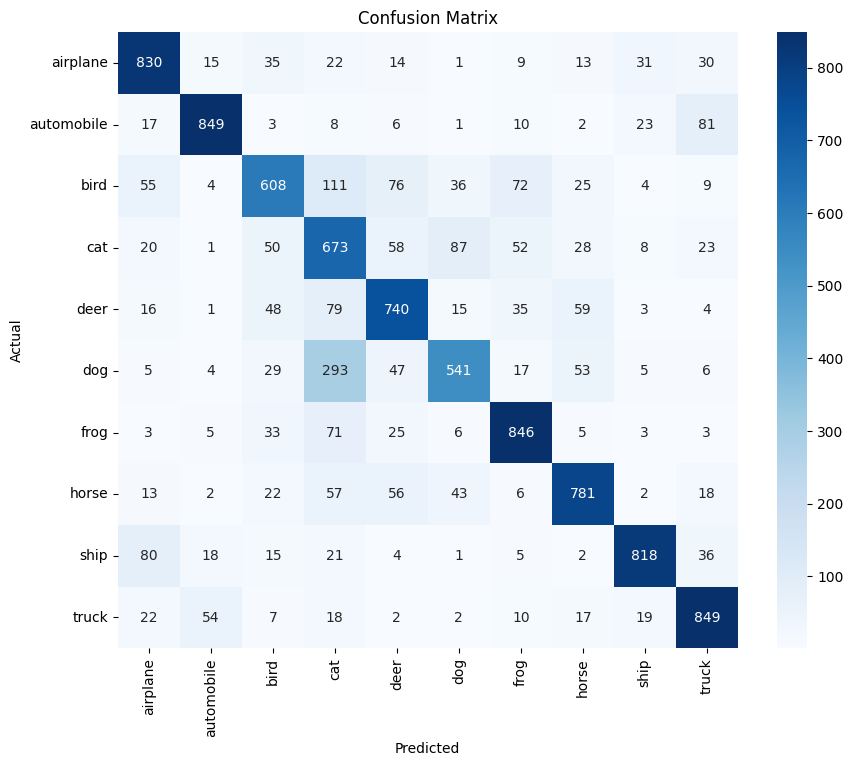

In [70]:
# Вычисление и визуализация матрицы ошибок
confusion_mtx = confusion_matrix(y_true, y_pred)  # Вычисляем матрицу ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [71]:
confusion_mtx

array([[830,  15,  35,  22,  14,   1,   9,  13,  31,  30],
       [ 17, 849,   3,   8,   6,   1,  10,   2,  23,  81],
       [ 55,   4, 608, 111,  76,  36,  72,  25,   4,   9],
       [ 20,   1,  50, 673,  58,  87,  52,  28,   8,  23],
       [ 16,   1,  48,  79, 740,  15,  35,  59,   3,   4],
       [  5,   4,  29, 293,  47, 541,  17,  53,   5,   6],
       [  3,   5,  33,  71,  25,   6, 846,   5,   3,   3],
       [ 13,   2,  22,  57,  56,  43,   6, 781,   2,  18],
       [ 80,  18,  15,  21,   4,   1,   5,   2, 818,  36],
       [ 22,  54,   7,  18,   2,   2,  10,  17,  19, 849]])

## Результаты и Выводы.

### Сравнительный анализ архитектур нейронных сетей в PyTorch



### 1. **ResNet (Residual Networks)**
- **Преимущества**: Позволяет обучать глубокие сети, решая проблему исчезающих градиентов за счет остаточных связей[1][2].
- **Недостатки**: Может быть сложна в реализации для начинающих.
- **Применение**: Подходит для задач, требующих глубоких моделей, таких как классификация изображений на больших наборах данных.
- **Сложность**: Средняя до высокой.

### 2. **VGG (Visual Geometry Group)**
- **Преимущества**: Простая и модульная архитектура, легко модифицируется[1].
- **Недостатки**: Большое количество параметров, что может привести к переобучению.
- **Применение**: Подходит для задач, где требуется простота и гибкость.
- **Сложность**: Низкая до средней.

### 3. **GoogLeNet (Inception)**
- **Преимущества**: Эффективно использует ресурсы, уменьшая количество параметров за счет параллельных ветвей[3].
- **Недостатки**: Сложна в реализации и требует значительных вычислительных ресурсов.
- **Применение**: Подходит для задач, где важна эффективность и точность.
- **Сложность**: Высокая.

### 4. **LeNet**
- **Преимущества**: Простая и легкая в реализации, подходит для небольших задач.
- **Недостатки**: Ограниченная выразительная способность.
- **Применение**: Подходит для небольших задач классификации изображений.
- **Сложность**: Низкая.

### 5. **AlexNet**
- **Преимущества**: Была пионерской в использовании ReLU и Dropout, что улучшило обучение[3].
- **Недостатки**: Менее эффективна по сравнению с более современными моделями.
- **Применение**: Подходит для задач, где требуется базовая архитектура.
- **Сложность**: Средняя.

### Оценка полученых результатов обучения нейросети AlexNet.

1. Анализ процесса обучения

Изменения функции потерь

Потеря (Loss):
    На первой эпохе функция потерь составляет 1.8792, что указывает на то, что модель плохо обучена.
    Потеря постепенно уменьшается с каждой эпохой и достигает 0.3689 к десятой эпохе.
    Это снижение потерь указывает на то, что модель учится и улучшает свои предсказания.

Изменения точности

Точность (Accuracy):
    На первой эпохе точность составляет 42.07%, что также указывает на плохую производительность модели.
    Точность увеличивается до 76.12% к десятой эпохе.
    Это свидетельствует о том, что модель успешно обучается и улучшает свои предсказания.

2. Оценка результатов по классам

Классы с высокой точностью:

    Классы "plane", "car", "frog", "truck" имеют высокую точность (выше 80%).
    Это говорит о том, что модель хорошо распознает эти классы.

Классы с низкой точностью:

    Класс "dog" имеет наименьшую точность (54%), что указывает на проблемы с распознаванием этого класса.
    Класс "bird" также имеет низкую точность (61%), что может быть связано с визуальными схожестями с другими классами.

3. Матрица ошибок

Наиболее часто встречаемая ошибка в предсказании классов cat вместо dog - 293 случая.


### Выводы:

1. 
### Важно при построении модели учитывать послойное изменение размеров данных.

### Пример расчета размеров тензоров

Входные данные

    Размер: (3, 32, 32) — это RGB-изображение с тремя каналами и размером 32x32 пикселя.

Слой 1: conv1

    Операция: self.conv1 = nn.Conv2d(3, 64, kernel_size=3)
    Выходной размер:
        Формула для вычисления размера выходного тензора:
        Output size = (Input size − Kernel size / Stride + 1)
        Применяя формулу:
        Output height=(32−3/1+1)=30
        Output width=(32−3/1+1)=30
        Итог: (64, 30, 30) — выход имеет 64 канала.

Слой 2: pool после conv1

    Операция: self.pool
    Выходной размер:
        Пулинг с kernel_size=2 и stride=2:
        Output height=(30−2/2+1)=15
        Output width=(30−2/2+1)=15
        Итог: (64, 15, 15)

Слой 3: conv2

    Операция: self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
    Выходной размер:
        Применяем ту же формулу:
        Output height=(15−3/1+1)=13
        Output width=(15−3/1+1)=13
        Итог: (128, 13, 13)

Слой 4: pool после conv2

    Операция: self.pool
    Выходной размер:
        Пулинг с kernel_size=2 и stride=2:
        Output height=(13−2/2+1)=6
        Output width=(13−2/2+1)=6
        Итог: (128, 6, 6)

Слой 5: conv3

    Операция: self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    Выходной размер:
        Поскольку используется padding=1, выход будет:
        Output height=(6−3+2/1+1)=6
        Output width=(6−3+2/1+1)=6
        Итог: (256, 6, 6)

Слой 6: conv4

    Операция: self.conv4
    Выходной размер:
        Аналогично предыдущему слою с использованием padding=1:
        Итог: (512, 6, 6)

Слой 7: conv5

    Операция: self.conv5
    Выходной размер:
        Аналогично предыдущему слою с использованием padding=1:
        Итог: (512, 6, 6)

Слой после последнего pool

    Операция: Пулинг с kernel_size=2 и stride=2:
        Выходной размер будет:
        Output height=(6−2/2+1)=3
        Output width=(6−2/2+1)=3
        Итог: (512, 3, 3)

Подготовка к полносвязному слою
Теперь перед полносвязным слоем мы должны изменить форму тензора:

x.view(-1, 512 * 3 * 3)

Здесь мы получаем вход для первого полносвязного слоя:
512∗3∗3=4608
512∗3∗3=4608
Полносвязные слои
Теперь у нас есть:

    Вход в первый полносвязный слой (fc1) будет иметь размерность (batch_size, 4608).










2. 
### Poolling  

self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

Размер выходных данных: 

Увеличение размера ядра до 3 может привести к более значительному уменьшению размерности выходных данных по сравнению с использованием ядра размером 2. Это может привести к более агрессивному уменьшению пространственных размеров feature maps.

Извлечение признаков: 

С увеличением размера ядра может быть потеряно больше информации о пространственных признаках изображения. Это может как помочь в извлечении более значительных признаков (за счет большего охвата), так и ухудшить качество распознавания из-за потери мелких деталей.

В данной работе уменьшение ядра с 3 до 2 - улучшило качество модели. 

3. 
### dataloader.batch_size

Выбор значения batch_size в DataLoader может существенно повлиять на скорость обучения модели. Однако, оптимальное значение batch_size зависит от нескольких факторов:

Оперативная память (RAM/GPU память): Если batch_size слишком велик, можно столкнуться с нехваткой памяти. В этом случае обучение будет прерываться.

Производительность: Большой batch_size обычно позволяет лучше использовать параллелизм на GPU, что может ускорить процесс обучения. Однако, если batch_size слишком велик, это может привести к ухудшению сходимости модели.

Сходимость: Меньший batch_size может привести к более частым обновлениям весов, что может помочь модели более эффективно находить оптимальное решение, но при этом процесс обучения может занять больше времени.


4. 
### Подбор learning_rate

Подбор learning rate (темпа обучения) является одним из наиболее критически важных факторов при обучении нейронных сетей. Learning rate определяет, насколько сильно обновляются веса модели в процессе обучения на каждом шаге.

Сходимость: Правильный выбор learning rate влияет на то, насколько быстро и эффективно модель будет сходиться. Слишком большой learning rate может привести к расхождению, когда модель не может найти оптимальное решение, так как шаги обновления слишком велики и перешагивают через минимум функции потерь. В то время как слишком маленький learning rate может замедлить процесс обучения, делая его неэффективным.

Стабильность: Высокий learning rate может вызвать колебания в значениях функции потерь. Это может привести к нестабильному обучению, когда модель не может найти надежный минимум. Низкий learning rate, хотя и более стабильный, может застревать в локальных минимумах и не достигать глобального минимума.

Общая производительность модели: Learning rate влияет на качество итоговой модели. Хорошо подобранный learning rate может значительно улучшить точность модели.

Правильный выбор learning rate — это не просто технический аспект, а один из ключевых факторов, определяющих успех обучения модели.


### Резюме.

Модель показывает положительную динамику в обучении и достигла хороших результатов по большинству классов в наборе данных CIFAR-10 после десяти эпох обучения. Однако есть возможности для дальнейшего улучшения производительности модели через аугментацию данных и тонкую настройку гиперпараметров.